# University of science
## Advanced Machine Learning - Lab 05
## Nguyễn Quốc Bảo - 18110053

Lab05:

Ở Bài thực hành này ta sx làm quen với data dạng sequence 

Chúng ta sẽ thực hành trên dataset về spam detection, đây là data về việc phát hiện có phải là spam hay không do đó gồm có 2 nhãn là spam và not spam

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
from tensorflow import keras
from time import time
from tensorflow.keras.layers import Input, Dense, Convolution2D, MaxPool2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Read data

In [ ]:
#đọc data
df = pd.read_csv("https://raw.githubusercontent.com/huynhthanh98/AML/main/lab-04/spam_detection.csv")
df.head()

,Text,Label,y
0,"Go until jurong point, crazy.. Available only ...",ham,0
1,Ok lar... Joking wif u oni...,ham,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,1
3,U dun say so early hor... U c already then say...,ham,0
4,"Nah I don't think he goes to usf, he lives aro...",ham,0


In [ ]:
nltk.download('punkt')
texts = df["Text"].to_list()
texts = [text.lower() for text in texts ]           # chuyển các đoạn text thành chữ thường (word embedding chỉ cho chữ thường)
tokenized_texts = [nltk.tokenize.word_tokenize(text) for text in texts]    # tách câu thành một list các từ

print(tokenized_texts[10])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
['i', "'m", 'gon', 'na', 'be', 'home', 'soon', 'and', 'i', 'do', "n't", 'want', 'to', 'talk', 'about', 'this', 'stuff', 'anymore', 'tonight', ',', 'k', '?', 'i', "'ve", 'cried', 'enough', 'today', '.']


Để Vectorize các câu ta sử dụng một bộ trọng số có tên là Glove do Stanford phát triển. bộ weights này sẽ biến mỗi chữ thành 1 vector có số nhiều là 50, 100, 200, hoặc 300. Số chiều càng lớn thì vector sẽ càng biểu diễn được ngữ nghĩa của một từ 

In [ ]:
#Tải bộ weights Glove
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-11-20 04:27:54--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-11-20 04:27:54--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-11-20 04:27:55--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
#Giải Nén
! unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
## không cần hiểu đống này lắm đâu
import io
def load_word_embeddings(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    vocab, matrix = [], []
    i=0
    for line in fin:
        tokens = line.rstrip().split(' ')
        vocab.append(tokens[0])
        matrix.append(list(map(float, tokens[1:])))
    return vocab, np.asarray(matrix)

In [ ]:
#vocab là bộ từ điển các từ có trong Glove
#matrix chứa các vector biểu diễn các từ 
##Ta chọn bộ weighs có số chiều là 100
vocab, matrix = load_word_embeddings("glove.6B.100d.txt")

In [ ]:
vocab[0]

'the'

In [ ]:
matrix[0].shape

(100,)

In [ ]:
#in thử shape của matrix
##Ta có thể thấy bộ từ điển này có 400000, mỗi từ là 1 vecotr có 100 chiều 
matrix.shape

(400000, 100)

In [ ]:

## Gán các mã
__PADDED_INDEX__ = 0    # mã dùng cho các vị trí chỉ có tính nối dài cho cùng kích thước
__UNKNOWN_WORD__ = 1    # mã cho những từ không có trong embedding

In [ ]:
# Tạo một dictionary, có nhiệm vụ là một ánh xạ từ ảnh sang mã số, mã số được bắt đầu từ 2 vì số 0 và 1 được dành cho trường hợp đặc biệt
word_to_index = {word: index+2 for index, word in enumerate(vocab)}

In [ ]:
# Do do mã số được bắt đầu từ 2, nên cần thêm 2 vector vào đàu ma trận
embedding_matrix = np.pad(matrix, ((2,0),(0,0)), mode='constant', constant_values =0.0)
print(embedding_matrix)

[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [-0.038194 -0.24487   0.72812  ... -0.1459    0.8278    0.27062 ]
 ...
 [ 0.36088  -0.16919  -0.32704  ...  0.27139  -0.29188   0.16109 ]
 [-0.10461  -0.5047   -0.49331  ...  0.42527  -0.5125   -0.17054 ]
 [ 0.28365  -0.6263   -0.44351  ...  0.43678  -0.82607  -0.15701 ]]


In [ ]:
## Bây giờ ta sẽ chuyển data spam dection thành các mã số

X = []
for text in tokenized_texts:
    cur_text_indices = []
    for word in text:
        if word in word_to_index:
            cur_text_indices.append(word_to_index[word])    ## map từ word sang index
        else:
            cur_text_indices.append(__UNKNOWN_WORD__)       ## gán unknown cho từ không có trong bộ glove
    X.append(cur_text_indices)

## pad data cho có cùng chiều dài
X = tf.keras.preprocessing.sequence.pad_sequences(sequences=X,       # sequences: list các câu có độ dài không bằng nhau
                                                  padding='post')    # vị trí pad là 'pre' (trước) hoặc 'post' (sau)

y = df['y'].values   ## Label của bài toán, 0 là không phải spam, 1 là spam

In [ ]:
## Chia data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state =0)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size= 0.1)

In [ ]:
X_train.shape

(4013, 215)

In [ ]:
SEQUENCE_LENGTH = 100 # the length of all sequences (number of words per sample)
EMBEDDING_SIZE = 100  # Using 100-Dimensional GloVe embedding vectors

label2int = {"ham": 0, "spam": 1}
int2label = {0: "ham", 1: "spam"}

tokenizer = Tokenizer()

In [ ]:
def get_predictions(text):
    sequence = tokenizer.texts_to_sequences([text])
    # pad the sequence
    sequence = pad_sequences(sequence, maxlen=SEQUENCE_LENGTH)
    # get the prediction
    prediction = model.predict(sequence)[0]
    # one-hot encoded vector, revert using np.argmax
    return int2label[np.argmax(prediction)]

In [ ]:
compare_result = {'acc_lstm':[], 'time_lstm':[], 'acc_gru':[], 'time_gru':[]}

# LSTM 1

In [ ]:
inputs = Input(shape=(None,))                   ## None biểu thị kích thước không xác định của câu

embed = Embedding(input_dim=embedding_matrix.shape[0],   ## Khai báo kích thước của vocab
                 output_dim=embedding_matrix.shape[1],   ## Khai báo kích thước của embedding
                  embeddings_initializer = tf.keras.initializers.Constant(value=embedding_matrix),  ## Khởi tạo cho embedding bằng ma trận có sẵn
                  trainable=False,                       ## Không cần thiết train embedding
                 mask_zero=True)(inputs)                 ## zero_mask: những vị trí có giá trị 0 không được tính toán, vì đó là giá trị thêm vào cho đủ độ dài mà thôi
                                                         ##  (__PADDED_INDEX__ gán bằng 0)

lstm = LSTM(units=100,                          ## units: kích thước của hidden_state trong LSTM
            return_sequences=False)(embed)      ## return_sequences: LSTM trả về toàn bộ  hay là trả về hidden_state cuối cùng

dense = Dense(units=2, activation='softmax')(lstm)
model = Model(inputs=inputs,
              outputs=dense, name='LSTM_1')

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "LSTM_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         40000200  
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 40,080,802
Trainable params: 80,602
Non-trainable params: 40,000,200
_________________________________________________________________


In [ ]:
# Checkpoint Callback
mc = keras.callbacks.ModelCheckpoint(filepath="/content/LSTM_1.hdf5", 
                                     monitor='val_loss',
                                     mode='min', 
                                     verbose=0, 
                                     save_best_only=True)
start = time()
## Train  ## Khuyến cáo chạy COLAB (hoặc tương tự)
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[mc])
end = time()-start
print(end)
compare_result['time_lstm'].append(end)   

Epoch 1/10
32/32 [==============================] - 41s 1s/step - loss: 0.2630 - accuracy: 0.9083 - val_loss: 0.1091 - val_accuracy: 0.9596
Epoch 2/10
32/32 [==============================] - 42s 1s/step - loss: 0.1006 - accuracy: 0.9661 - val_loss: 0.1037 - val_accuracy: 0.9552
Epoch 3/10
32/32 [==============================] - 60s 2s/step - loss: 0.0919 - accuracy: 0.9701 - val_loss: 0.0591 - val_accuracy: 0.9843
Epoch 4/10
32/32 [==============================] - 52s 2s/step - loss: 0.0614 - accuracy: 0.9836 - val_loss: 0.0510 - val_accuracy: 0.9821
Epoch 5/10
32/32 [==============================] - 46s 1s/step - loss: 0.0547 - accuracy: 0.9858 - val_loss: 0.0490 - val_accuracy: 0.9798
Epoch 6/10
32/32 [==============================] - 1s 33ms/step - loss: 0.0537 - accuracy: 0.9833 - val_loss: 0.1512 - val_accuracy: 0.9283
Epoch 7/10
32/32 [==============================] - 1s 33ms/step - loss: 0.0601 - accuracy: 0.9796 - val_loss: 0.0560 - val_accuracy: 0.9776
Epoch 8/10
32/32 [

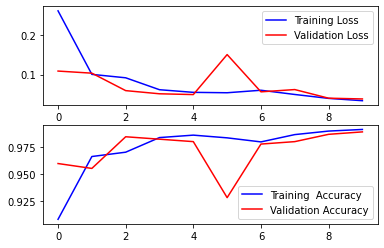

In [ ]:
f,ax=plt.subplots(2,1) 


ax[0].plot(history.history['loss'],color='b',label='Training Loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(history.history['val_accuracy'],color='r',label='Validation Accuracy')

ax[1].legend()
plt.show()

In [ ]:
model.load_weights("/content/LSTM_1.hdf5")
val_loss, val_acc = model.evaluate(X_test, y_test)
print(f"Accuracy: {val_acc} and loss: {val_loss} on test")
compare_result['acc_lstm'].append(val_acc) 

35/35 [==============================] - 0s 9ms/step - loss: 0.0609 - accuracy: 0.9803
Accuracy: 0.9802690744400024 and loss: 0.060885872691869736 on test


In [ ]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [ ]:
SEQUENCE_LENGTH = 100 # the length of all sequences (number of words per sample)

for q in quotes:
    seq = q.lower()
    print(seq)
    print(get_predictions(seq))
    print()

it is not a lack of love, but a lack of friendship that makes unhappy marriages.
ham

that which does not kill us makes us stronger.
ham

i'm not upset that you lied to me, i'm upset that from now on i can't believe you.
ham

and those who were seen dancing were thought to be insane by those who could not hear the music.
ham

it is hard enough to remember my opinions, without also remembering my reasons for them!
ham



In [ ]:
lstm[2]

<KerasTensor: shape=(100,) dtype=float32 (created by layer 'tf.__operators__.getitem')>

In [ ]:
lstm[1]

<KerasTensor: shape=(100,) dtype=float32 (created by layer 'tf.__operators__.getitem_1')>

In [ ]:
embedding_matrix.shape[0]

400002

# LSTM 2

In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, GRU, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# inputs = Input(shape=(100,))                   ## None biểu thị kích thước không xác định của câu
inputs = Input(shape=(215,)) 
embed = Embedding(input_dim=embedding_matrix.shape[0],   ## Khai báo kích thước của vocab
                 output_dim=embedding_matrix.shape[1],   ## Khai báo kích thước của embedding
                  embeddings_initializer = tf.keras.initializers.Constant(value=embedding_matrix),  ## Khởi tạo cho embedding bằng ma trận có sẵn
                  trainable=False,                       ## Không cần thiết train embedding
                 mask_zero=True)(inputs)                 ## zero_mask: những vị trí có giá trị 0 không được tính toán, vì đó là giá trị thêm vào cho đủ độ dài mà thôi
                                                         ##  (__PADDED_INDEX__ gán bằng 0)

lstm = LSTM(units=100,                          ## units: kích thước của hidden_state trong LSTM
            return_sequences=True,          
           return_state=True)(embed)      ## return_sequences: LSTM trả về toàn bộ  hay là trả về hidden_state cuối cùng
                                        ## return_state: in toàn bộ output của hidden_state
print(lstm)
global_maxpool = GlobalAveragePooling1D()(lstm[0])
dense = Dense(units=2, activation='softmax')(global_maxpool)
model = Model(inputs=inputs,
              outputs=dense, name='LSTM_2')

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

[<KerasTensor: shape=(None, 215, 100) dtype=float32 (created by layer 'lstm_1')>, <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'lstm_1')>, <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'lstm_1')>]
Model: "LSTM_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 215)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 215, 100)          40000200  
                                                                 
 lstm_1 (LSTM)               [(None, 215, 100),        80400     
                              (None, 100),                       
                              (None, 100)]                       
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D) 

In [ ]:
# Checkpoint Callback
mc = keras.callbacks.ModelCheckpoint(filepath="/content/LSTM_2.hdf5", 
                                     monitor='val_loss',
                                     mode='min', 
                                     verbose=0, 
                                     save_best_only=True)
start = time()
## Train  ## Khuyến cáo chạy COLAB (hoặc tương tự)
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[mc])
end = time()-start
print(end)
compare_result['time_lstm'].append(end)  

Epoch 1/10
32/32 [==============================] - 54s 2s/step - loss: 0.3530 - accuracy: 0.8537 - val_loss: 0.2511 - val_accuracy: 0.8610
Epoch 2/10
32/32 [==============================] - 54s 2s/step - loss: 0.1542 - accuracy: 0.9452 - val_loss: 0.1146 - val_accuracy: 0.9664
Epoch 3/10
32/32 [==============================] - 29s 931ms/step - loss: 0.0918 - accuracy: 0.9723 - val_loss: 0.0860 - val_accuracy: 0.9686
Epoch 4/10
32/32 [==============================] - 1s 33ms/step - loss: 0.0897 - accuracy: 0.9703 - val_loss: 0.1105 - val_accuracy: 0.9507
Epoch 5/10
32/32 [==============================] - 29s 932ms/step - loss: 0.0690 - accuracy: 0.9763 - val_loss: 0.0666 - val_accuracy: 0.9753
Epoch 6/10
32/32 [==============================] - 30s 969ms/step - loss: 0.0572 - accuracy: 0.9818 - val_loss: 0.0657 - val_accuracy: 0.9709
Epoch 7/10
32/32 [==============================] - 29s 933ms/step - loss: 0.0509 - accuracy: 0.9846 - val_loss: 0.0632 - val_accuracy: 0.9686
Epoch 8

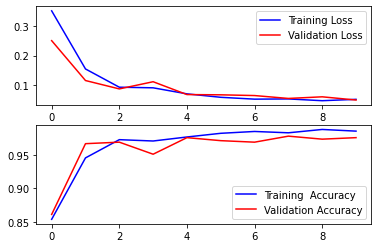

In [ ]:
f,ax=plt.subplots(2,1) 


ax[0].plot(history.history['loss'],color='b',label='Training Loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(history.history['val_accuracy'],color='r',label='Validation Accuracy')

ax[1].legend()
plt.show()

In [ ]:
model.load_weights("/content/LSTM_2.hdf5")
val_loss, val_acc = model.evaluate(X_test, y_test)
print(f"Accuracy: {val_acc} and loss: {val_loss} on test")
compare_result['acc_lstm'].append(val_acc) 

35/35 [==============================] - 0s 9ms/step - loss: 0.0799 - accuracy: 0.9677
Accuracy: 0.9677129983901978 and loss: 0.07988902926445007 on test


In [ ]:
SEQUENCE_LENGTH = 215
for q in quotes:
    seq = q.lower()
    print(seq)
    print(get_predictions(seq))
    print()

it is not a lack of love, but a lack of friendship that makes unhappy marriages.
ham

that which does not kill us makes us stronger.
ham

i'm not upset that you lied to me, i'm upset that from now on i can't believe you.
ham

and those who were seen dancing were thought to be insane by those who could not hear the music.
ham

it is hard enough to remember my opinions, without also remembering my reasons for them!
ham



# Bài Tập
1. Tìm hiểu về cách dùng của GRU và chạy theo 2 cách hướng dẫn ở trên 


# GRU 1

In [ ]:
from keras.layers import GRU

inputs = Input(shape=(None,))                   ## None biểu thị kích thước không xác định của câu

embed = Embedding(input_dim=embedding_matrix.shape[0],   ## Khai báo kích thước của vocab
                 output_dim=embedding_matrix.shape[1],   ## Khai báo kích thước của embedding
                  embeddings_initializer = tf.keras.initializers.Constant(value=embedding_matrix),  ## Khởi tạo cho embedding bằng ma trận có sẵn
                  trainable=False,                       ## Không cần thiết train embedding
                 mask_zero=True)(inputs)                 ## zero_mask: những vị trí có giá trị 0 không được tính toán, vì đó là giá trị thêm vào cho đủ độ dài mà thôi
                                                         ##  (__PADDED_INDEX__ gán bằng 0)

gru = GRU(units=100,                          ## units: kích thước của hidden_state trong GRU
            return_sequences=False)(embed)      ## return_sequences: GRU trả về toàn bộ  hay là trả về hidden_state cuối cùng

dense = Dense(units=2, activation='softmax')(gru)
model = Model(inputs=inputs,
              outputs=dense, name='GRU_1')

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "GRU_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 100)         40000200  
                                                                 
 gru (GRU)                   (None, 100)               60600     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 40,061,002
Trainable params: 60,802
Non-trainable params: 40,000,200
_________________________________________________________________


In [ ]:
# Checkpoint Callback
mc = keras.callbacks.ModelCheckpoint(filepath="/content/GRU_1.hdf5", 
                                     monitor='val_loss',
                                     mode='min', 
                                     verbose=0, 
                                     save_best_only=True)
start = time()
## Train  ## Khuyến cáo chạy COLAB (hoặc tương tự)
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[mc])
end = time()-start
print(end)
compare_result['time_gru'].append(end) 

Epoch 1/10
32/32 [==============================] - 35s 963ms/step - loss: 0.3364 - accuracy: 0.8512 - val_loss: 0.2894 - val_accuracy: 0.8632
Epoch 2/10
32/32 [==============================] - 27s 880ms/step - loss: 0.2179 - accuracy: 0.9145 - val_loss: 0.1254 - val_accuracy: 0.9574
Epoch 3/10
32/32 [==============================] - 28s 903ms/step - loss: 0.1014 - accuracy: 0.9674 - val_loss: 0.0869 - val_accuracy: 0.9731
Epoch 4/10
32/32 [==============================] - 27s 885ms/step - loss: 0.0742 - accuracy: 0.9763 - val_loss: 0.0483 - val_accuracy: 0.9798
Epoch 5/10
32/32 [==============================] - 28s 891ms/step - loss: 0.0555 - accuracy: 0.9841 - val_loss: 0.0424 - val_accuracy: 0.9888
Epoch 6/10
32/32 [==============================] - 1s 29ms/step - loss: 0.0474 - accuracy: 0.9855 - val_loss: 0.0460 - val_accuracy: 0.9843
Epoch 7/10
32/32 [==============================] - 27s 880ms/step - loss: 0.0421 - accuracy: 0.9883 - val_loss: 0.0377 - val_accuracy: 0.9888
E

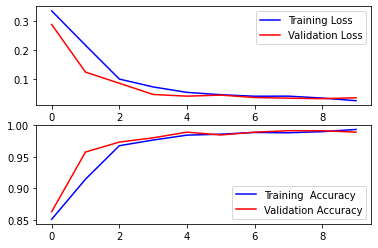

In [ ]:
f,ax=plt.subplots(2,1) 


ax[0].plot(history.history['loss'],color='b',label='Training Loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(history.history['val_accuracy'],color='r',label='Validation Accuracy')

ax[1].legend()
plt.show()

In [ ]:
model.load_weights("/content/GRU_1.hdf5")
val_loss, val_acc = model.evaluate(X_test, y_test)
print(f"Accuracy: {val_acc} and loss: {val_loss} on test")
compare_result['acc_gru'].append(val_acc) 

35/35 [==============================] - 0s 8ms/step - loss: 0.0566 - accuracy: 0.9821
Accuracy: 0.9820627570152283 and loss: 0.05661835893988609 on test


In [ ]:
SEQUENCE_LENGTH = 100
for q in quotes:
    seq = q.lower()
    print(seq)
    print(get_predictions(seq))
    print()

it is not a lack of love, but a lack of friendship that makes unhappy marriages.
ham

that which does not kill us makes us stronger.
ham

i'm not upset that you lied to me, i'm upset that from now on i can't believe you.
ham

and those who were seen dancing were thought to be insane by those who could not hear the music.
ham

it is hard enough to remember my opinions, without also remembering my reasons for them!
ham



# GRU 2

In [ ]:
inputs = Input(shape=(215,))                   ## None biểu thị kích thước không xác định của câu

embed = Embedding(input_dim=embedding_matrix.shape[0],   ## Khai báo kích thước của vocab
                 output_dim=embedding_matrix.shape[1],   ## Khai báo kích thước của embedding
                  embeddings_initializer = tf.keras.initializers.Constant(value=embedding_matrix),  ## Khởi tạo cho embedding bằng ma trận có sẵn
                  trainable=False,                       ## Không cần thiết train embedding
                 mask_zero=True)(inputs)                 ## zero_mask: những vị trí có giá trị 0 không được tính toán, vì đó là giá trị thêm vào cho đủ độ dài mà thôi
                                                         ##  (__PADDED_INDEX__ gán bằng 0)

gru = GRU(units=100,                          ## units: kích thước của hidden_state trong GRU
            return_sequences=True,
           return_state=True)(embed)      ## return_sequences: GRU trả về toàn bộ  hay là trả về hidden_state cuối cùng
print(gru)
global_maxpool = GlobalAveragePooling1D()(gru[0])
dense = Dense(units=2, activation='softmax')(global_maxpool)
model = Model(inputs=inputs,
              outputs=dense, name='GRU_2')

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

[<KerasTensor: shape=(None, 215, 100) dtype=float32 (created by layer 'gru_1')>, <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'gru_1')>]
Model: "GRU_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 215)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 215, 100)          40000200  
                                                                 
 gru_1 (GRU)                 [(None, 215, 100),        60600     
                              (None, 100)]                       
                                                                 
 global_average_pooling1d_1   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 2

In [ ]:
# Checkpoint Callback
mc = keras.callbacks.ModelCheckpoint(filepath="/content/GRU_2.hdf5", 
                                     monitor='val_loss',
                                     mode='min', 
                                     verbose=0, 
                                     save_best_only=True)
start = time()
## Train  ## Khuyến cáo chạy COLAB (hoặc tương tự)
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[mc])
end = time()-start
print(end)
compare_result['time_gru'].append(end)   

Epoch 1/10
32/32 [==============================] - 39s 1s/step - loss: 0.3112 - accuracy: 0.8754 - val_loss: 0.2264 - val_accuracy: 0.9126
Epoch 2/10
32/32 [==============================] - 30s 961ms/step - loss: 0.1405 - accuracy: 0.9502 - val_loss: 0.1042 - val_accuracy: 0.9731
Epoch 3/10
32/32 [==============================] - 31s 1s/step - loss: 0.0881 - accuracy: 0.9684 - val_loss: 0.0737 - val_accuracy: 0.9709
Epoch 4/10
32/32 [==============================] - 30s 970ms/step - loss: 0.0712 - accuracy: 0.9738 - val_loss: 0.0718 - val_accuracy: 0.9709
Epoch 5/10
32/32 [==============================] - 30s 953ms/step - loss: 0.0610 - accuracy: 0.9801 - val_loss: 0.0558 - val_accuracy: 0.9776
Epoch 6/10
32/32 [==============================] - 1s 31ms/step - loss: 0.0510 - accuracy: 0.9836 - val_loss: 0.0569 - val_accuracy: 0.9776
Epoch 7/10
32/32 [==============================] - 31s 1s/step - loss: 0.0514 - accuracy: 0.9846 - val_loss: 0.0477 - val_accuracy: 0.9888
Epoch 8/10

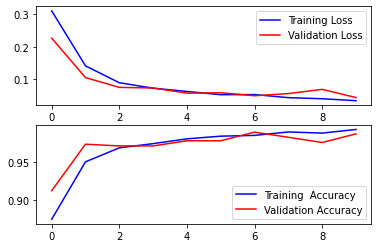

In [ ]:
f,ax=plt.subplots(2,1) 


ax[0].plot(history.history['loss'],color='b',label='Training Loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(history.history['val_accuracy'],color='r',label='Validation Accuracy')

ax[1].legend()
plt.show()

In [ ]:
model.load_weights("/content/GRU_2.hdf5")
val_loss, val_acc = model.evaluate(X_test, y_test)
print(f"Accuracy: {val_acc} and loss: {val_loss} on test")
compare_result['acc_gru'].append(val_acc)

35/35 [==============================] - 0s 9ms/step - loss: 0.0711 - accuracy: 0.9740
Accuracy: 0.9739910364151001 and loss: 0.07113027572631836 on test


In [ ]:
SEQUENCE_LENGTH = 215
for q in quotes:
    seq = q.lower()
    print(seq)
    print(get_predictions(seq))
    print()

it is not a lack of love, but a lack of friendship that makes unhappy marriages.
ham

that which does not kill us makes us stronger.
ham

i'm not upset that you lied to me, i'm upset that from now on i can't believe you.
ham

and those who were seen dancing were thought to be insane by those who could not hear the music.
ham

it is hard enough to remember my opinions, without also remembering my reasons for them!
ham



In [ ]:
compare_result

{'acc_gru': [0.9820627570152283, 0.9739910364151001],
 'acc_lstm': [0.9802690744400024, 0.9677129983901978],
 'time_gru': [266.28504252433777, 265.83434867858887],
 'time_lstm': [336.06884145736694, 283.90527296066284]}

2. So sánh giữa 2 cấu trúc của GRU và LSTM. Từ đó đưa ra kết luận của mình (có dẫn chứng )

Có thể thấy kết quả ở trên, mức độ hiệu quả của cả LSTM và GRU đều tốt trên tập data spam detection này, nhưng cấu trúc thứ hai ổn định hơn so với cấu trúc thứ nhất vì khi thêm GlobalAveragePooling1D sẽ trả về một vecto đầu ra cố định. Còn về thời gian huấn luyện thì GRU nhanh hơn một chút so với LSTM. 